# Notebook for texture synthesis for MNIST

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


# Define the transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
])

# Load the MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)


DATASET_IMAGES = 60000
TESTSET_IMAGES = 500
# DataLoader
train_loader = DataLoader(mnist_train, batch_size=DATASET_IMAGES, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=TESTSET_IMAGES, shuffle=False)
 
# Move the data to the specified device (GPU 0)
training_images, training_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))


### Define input args

In [10]:
import datetime
from synthesis_mnist import *

window_size=(28,28)         # Generated image size, (height,width)
kernel_size=7               # history window size
seed_size=7

Synthesis finished. Time used: 10.4s


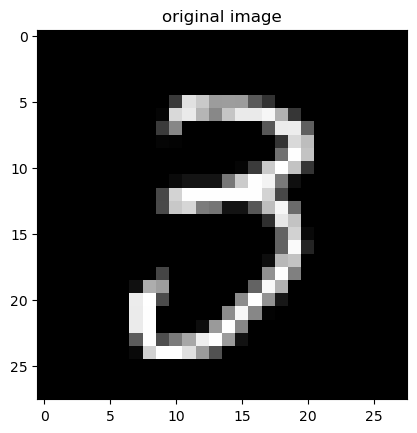

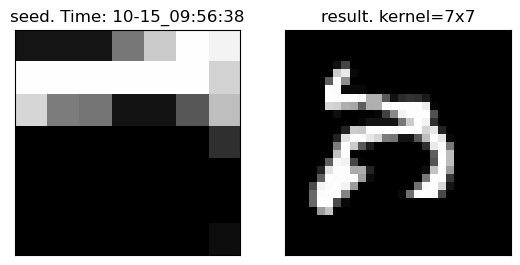

In [12]:
synthesized_texture = synthesize_texture(sample=training_images,
                                         test_sample=test_images,
                                         window_size=window_size, 
                                         kernel_size=kernel_size, 
                                         seed_size=seed_size)

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%m-%d_%H:%M:%S")  # Format: month-day hour:minute
out_path=f'outputs/mnist/{formatted_time}.png'

fig, [ax1, ax2] = plt.subplots(1,2)
ax2.imshow(synthesized_texture.to('cpu'), vmin=0, vmax=1, cmap='grey')
ax2.set(title=f'result. kernel={kernel_size}x{kernel_size}')
ax2.set_xticks([])
ax2.set_yticks([])

# Place seed in center of window

ph, pw = (window_size[0] - seed_size + 1) // 2, (window_size[1] - seed_size + 1) // 2
original_seed = synthesized_texture[ph:ph+seed_size, pw:pw+seed_size]
ax1.imshow(original_seed.to('cpu'), vmin=0, vmax=1, cmap='grey')
ax1.set(title=f'seed. Time: {formatted_time}')
ax1.set_xticks([])
ax1.set_yticks([])
fig.savefig(out_path)


In [6]:
fig.savefig(out_path)